In [53]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import numpy as np
import pathlib
import time
import cv2
import os
import random
import re

### Paths

In [58]:
images_path = 'teamphotos_ready/'

### Hyperparameters

In [59]:
images_num=20

train_size=0.6
test_val_proportion=0.5

image_shape=(224, 224, 3)

batch_size=10
lr=1e-5

## Creating pairs

In [60]:
def slicer(array, index_from, index_to):
    array_copy = array.copy()
    del array_copy[index_from:index_to]
    return array_copy

In [61]:
def get_balanced_pair(path):
    containing_id_list = []
    photos = os.listdir(path)
    photos.sort(key=lambda f: int(re.sub('\D', '', f)))
    
    photo_sample = random.sample(photos, 1)
    photo_sample = photo_sample[0]
    photo_index = photos.index(photo_sample)
    if photo_index % 2 == 1:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index - 1])
        negative = random.sample(slicer(photos, photo_index - 1, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]
    else:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index + 1])
        negative = random.sample(slicer(photos, photo_index, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]
    

In [62]:
def generate_pairs(pairs_num, images_path):
    balanced_pairs = []
    
    for i in range(pairs_num):
        pair = get_balanced_pair(images_path)
        balanced_pairs.append(pair[0])
        balanced_pairs.append(pair[1]) 
        
    df = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
    df['left'] = images_path  + df['left']
    df['right'] = images_path + df['right']
        
    return df

In [63]:
random.seed(64)
df_train = generate_pairs(images_num, images_path)

random.seed(128)
df_test = generate_pairs(images_num, images_path)

In [64]:
df_train.head()

,left,right,label
0,teamphotos_ready/16.jpg,teamphotos_ready/15.jpg,1
1,teamphotos_ready/16.jpg,teamphotos_ready/4.jpg,0
2,teamphotos_ready/21.jpg,teamphotos_ready/22.jpg,1
3,teamphotos_ready/21.jpg,teamphotos_ready/20.jpg,0
4,teamphotos_ready/13.jpg,teamphotos_ready/14.jpg,1


In [65]:
df_test.head()

,left,right,label
0,teamphotos_ready/8.jpg,teamphotos_ready/7.jpg,1
1,teamphotos_ready/8.jpg,teamphotos_ready/15.jpg,0
2,teamphotos_ready/17.jpg,teamphotos_ready/18.jpg,1
3,teamphotos_ready/17.jpg,teamphotos_ready/12.jpg,0
4,teamphotos_ready/5.jpg,teamphotos_ready/6.jpg,1


### Create test train val split

In [66]:
X_train = df_train[["left", "right"]]
Y_train_label = df_train[["label"]]

In [67]:
X_test = df_test[["left", "right"]]
Y_test_label = df_test[["label"]]

In [68]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

=====Training=====
(40, 2)
(40, 1)
=====Testing=====
(40, 2)
(40, 1)


### Loading pairs into TF Dataset

In [72]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resnet50 preprocessing removed as it's not used
    img = tf.reshape(img,image_shape)
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [73]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [74]:
train_ds = create_dataset(X_train, Y_train_label)
val_ds = create_dataset(X_test, Y_test_label)

## NN model

### Inputs

In [75]:
left_input = layers.Input(shape=image_shape, name='left_input')
right_input = layers.Input(shape=image_shape, name='right_input')

### ResNet50 model

### ResNet50 model

- 5th block (conv_5) set as trainable (33 layers)

In [76]:
trainable_layers=33 #whole conv_5 block

def resnet_embedding():
    input = layers.Input(shape=image_shape)
    
    resnet=ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=image_shape,
        pooling='avg',
        weights='imagenet',
        classes=2)

    # whole conv5 block
    for layer in resnet.layers[0:-trainable_layers]:
        layer.trainable = False

    return Model(input, outputs=resnet.output, name='resnet50')

### Convolutional NN 

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

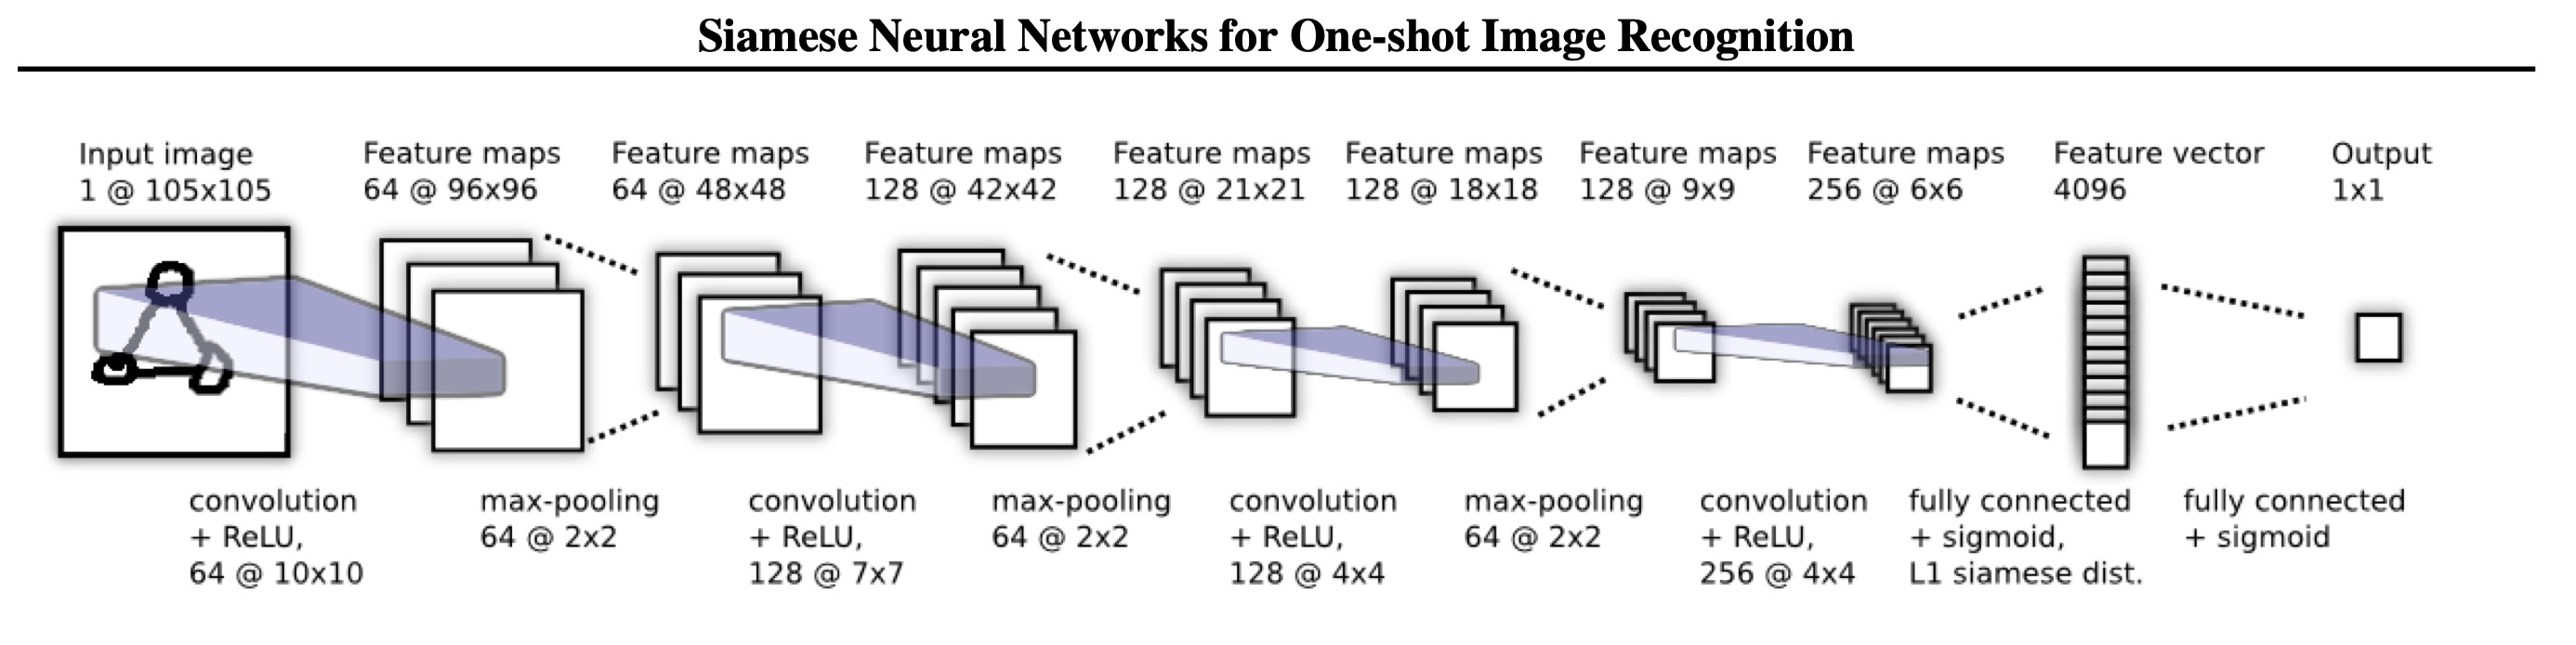

In [77]:
def conv_embedding(): 
    input = layers.Input(shape=image_shape, name='input_image')
    
    # First block
    c1 = layers.Conv2D(64, (10,10), activation='relu')(input)
    m1 = layers.MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = layers.Flatten()(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=input, outputs=d1, name='conv_net')

### Custom dense layers model

In [78]:
def base_embedding():
    input = layers.Input(shape=image_shape)
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='base_network')

In [79]:
#embedding = resnet_embedding()
#embedding = base_embedding()
embedding = conv_embedding()

embedding_left = embedding(left_input)
embeding_right = embedding(right_input)

### Merging resnet branches layers

In [80]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [81]:
#merged = layers.Subtract([model_left.output, model_right.output])
model = layers.Lambda(euclidean_distance, name="merge")([embedding_left, embeding_right])
model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model, name='conv_model')

In [82]:
model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy')

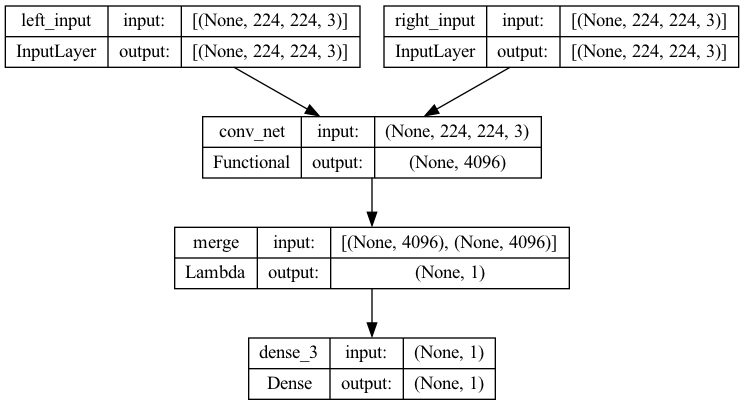

In [83]:
plot_model(model, show_shapes=True)

In [84]:
model.summary()

Model: "conv_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_net (Functional)          (None, 4096)         463633728   ['left_input[0][0]',             
                                                                  'right_input[0][0]']   

### 1. Load existing model from a checkpoint

In [50]:
checkpoint_dir = 'checkpoints/conv_net-20221128-173201'
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest_ckpt)

### 2.1. Train a new model

In [85]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15


2022-11-30 17:51:14.238230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 17:51:14.663008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6848

2022-11-30 17:51:40.112644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 27s 6s/step - loss: 0.6848 - val_loss: 0.6697
Epoch 2/15
4/4 [==============================] - 25s 6s/step - loss: 0.6427 - val_loss: 0.6523
Epoch 3/15
4/4 [==============================] - 25s 6s/step - loss: 0.6112 - val_loss: 0.6355
Epoch 4/15
4/4 [==============================] - 25s 6s/step - loss: 0.5813 - val_loss: 0.6165
Epoch 5/15
4/4 [==============================] - 25s 6s/step - loss: 0.5528 - val_loss: 0.5955
Epoch 6/15
4/4 [==============================] - 25s 6s/step - loss: 0.5261 - val_loss: 0.5747
Epoch 7/15
4/4 [==============================] - 25s 6s/step - loss: 0.5031 - val_loss: 0.5553
Epoch 8/15
4/4 [==============================] - 25s 6s/step - loss: 0.4781 - val_loss: 0.5435
Epoch 9/15
4/4 [==============================] - 25s 6s/step - loss: 0.4566 - val_loss: 0.5303
Epoch 10/15
4/4 [==============================] - 25s 6s/step - loss: 0.4379 - val_loss: 0.5230
Epoch 11/15
4/4 [==============================] -

### 2.2. Save trained model

In [51]:
# !cd {checkpoint_path} && mkdir {model_version}

checkpoints_path = 'checkpoints'
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'{checkpoints_path}/{model_version}'
model.save_weights(model_path)

### Performance metrics

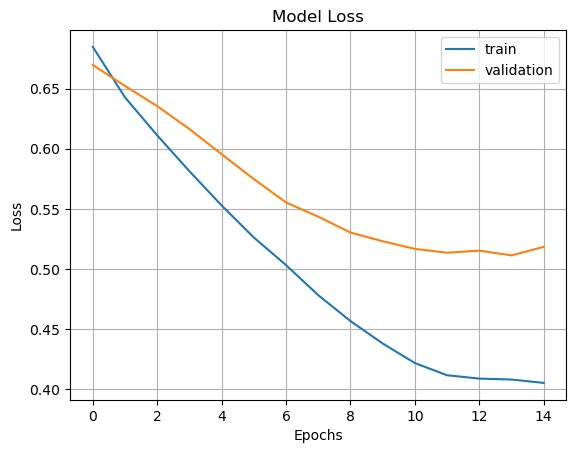

In [86]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Predictions

In [87]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

test_ds_full = create_dataset_no_labels(X_test)

In [92]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

4/4 [==============================] - 0s 125ms/step


In [93]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive distances

In [94]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    20.000000
mean      0.157590
std       0.115943
min       0.021401
25%       0.081896
50%       0.096404
75%       0.237254
max       0.403428
dtype: float64

### Negative distances

In [95]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    20.000000
mean      1.481276
std       1.072652
min       0.119887
25%       0.609447
50%       1.467770
75%       2.299912
max       3.273119
dtype: float64

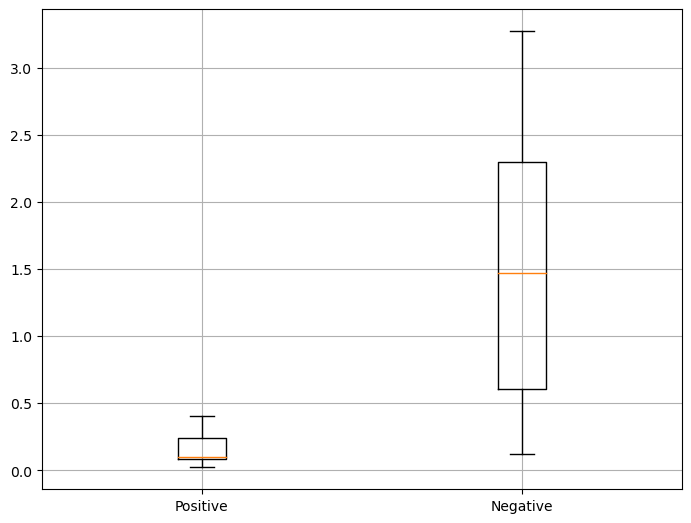

In [96]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [97]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [98]:
y_pred_test = euclidean_distance((left_image_feature_vectors, right_image_feature_vectors)).numpy().flatten()
cutoff = (positive_mean + negative_mean)/2

test_accuracy, y_pred = compute_accuracy(test_labels, y_pred_test, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 82.50%


nprecision = 0.74%
recall = 1.00%
F1 = 0.85%
accuracy = 0.82%



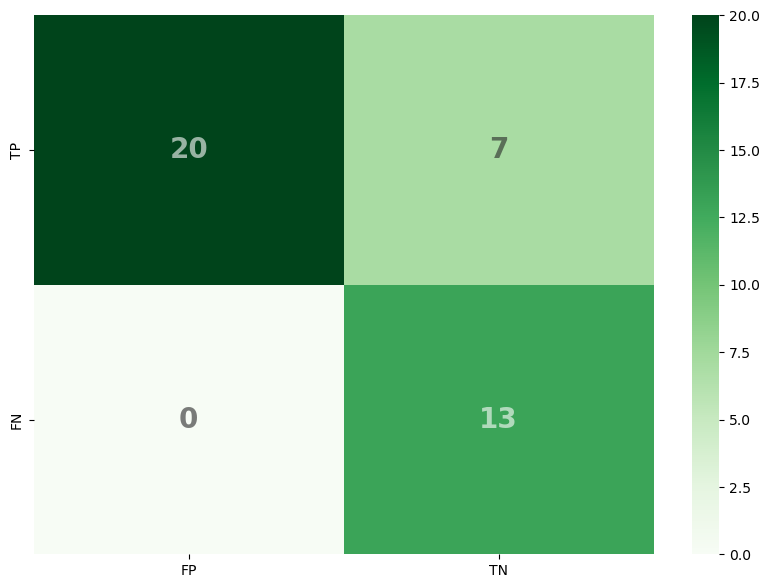

In [99]:
c_matrix = confusion_matrix(y_pred, test_labels, labels = [1,0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10,7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
          annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6})

report_lr = precision_recall_fscore_support(test_labels, y_pred, average='binary')

print (f'nprecision = %0.2f%%\nrecall = %0.2f%%\nF1 = %0.2f%%\naccuracy = %0.2f%%\n' % \
           (report_lr[0], report_lr[1], report_lr[2], accuracy_score(y_pred, test_labels)))

In [110]:
def display_images(left, right, predictions, title, n):
    fig, axarr = plt.subplots(2,10, figsize=(17,3))
    plt.setp(axarr, xticks=[], yticks=[])
    
    for image, i in zip(left, range(len(left))):
        img = cv2.imread(image)
        axarr[0,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axarr[0,i].grid(None)
        
    for image, i in zip(right, range(len(right))):
        img = cv2.imread(image)
        axarr[1,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axarr[1,i].grid(None)
        
        label = 'Same' if predictions[i].item() < cutoff else 'Different'
        
        axarr[1,i].set_xlabel(label)
        if predictions[i].item() > cutoff: 
            axarr[1,i].xaxis.label.set_color('red')
        else:
            axarr[1,i].xaxis.label.set_color('black')

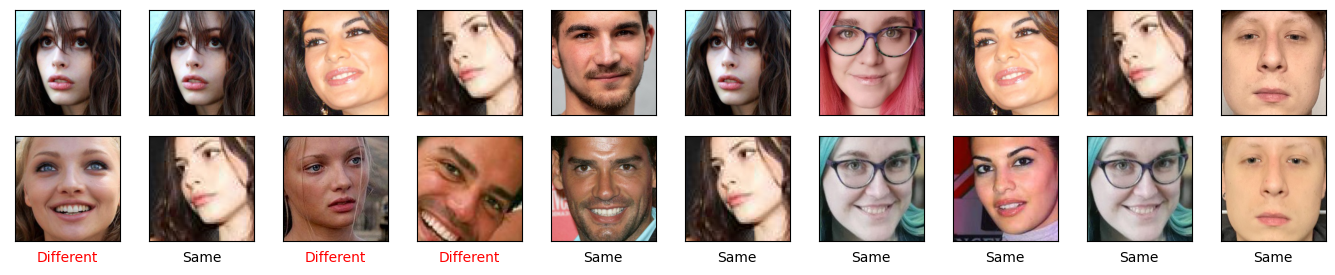

In [111]:
y_pred_test = np.squeeze(y_pred_test)
indexes = np.random.choice(len(y_pred_test), size=10)
display_images(X_test["left"][indexes],
               X_test["right"][indexes],
               y_pred_test[indexes],
               'Clothes and their dissimilarity', 10)

In [113]:
img_index = 0

#get prediction
print(y_pred_test[img_index].item() < cutoff)

True
